In [ ]:
import pandas as pd
import numpy as np
import re

COUNTRY_COLUMN='Country'
ENERJY_SUPPLY_COLUMN = '(GJ) Energy Supply'
ENERJY_PER_CAPITAL_COLUMN = '(GJ) Supply per Capital'
RENEWABLE_COLUMN = '% Renewable'

def load_energy_suply_table(path):
  # Load the Excel file while skipping the unnecessary rows and columns
  df = pd.read_excel(path, skiprows=16).drop(0).reset_index(drop=True).iloc[:227, 2:]


  df.columns = [COUNTRY_COLUMN, ENERJY_SUPPLY_COLUMN, ENERJY_PER_CAPITAL_COLUMN, RENEWABLE_COLUMN]

  def transform_table(df: pd.DataFrame) -> pd.DataFrame:
    def cast_to_float(x):
      if x == '...':
        return np.nan
      return x
    
    df[ENERJY_SUPPLY_COLUMN] = df[ENERJY_SUPPLY_COLUMN].apply(cast_to_float)
    df[ENERJY_PER_CAPITAL_COLUMN] = df[ENERJY_PER_CAPITAL_COLUMN].apply(cast_to_float)
    df[RENEWABLE_COLUMN] = df[RENEWABLE_COLUMN].apply(cast_to_float)

    GIGAJOULES_IN_ONE_PETAJOULE = 1000000

    df[ENERJY_SUPPLY_COLUMN] *= GIGAJOULES_IN_ONE_PETAJOULE

    return df
  
  df = transform_table(df)
  
  country_renames = {
    "Republic of Korea": "South Korea",
    "United States of America20": "United States",
    "United Kingdom of Great Britain and Northern Ireland19": "United Kingdom",
    "China, Hong Kong Special Administrative Region3": "Hong Kong"
  }

  def clean_country_name(old_name):
    if isinstance(old_name, str):
      name = country_renames.get(old_name, old_name)
      name = re.sub(r'\d+', '', name)  # Remove digits
      name = re.sub(r'\s*\(.*?\)\s*', '', name)  # Remove text within parentheses
      return name.strip()
    return old_name

  df[COUNTRY_COLUMN] = df[COUNTRY_COLUMN].apply(clean_country_name)
  
  return df

energy_suply = load_energy_suply_table('./En_In.xls')

energy_suply.loc[energy_suply['Country'].isin(['American Samoa', 'South Korea', 'Bolivia'])]


,Country,(GJ) Energy Supply,(GJ) Supply per Capital,% Renewable
3,American Samoa,NaN,NaN,0.641026
24,Bolivia,3.360000e+08,32.0,31.477120
164,South Korea,1.100700e+10,221.0,2.279353


In [ ]:
def load_GPD_table(path):
    # Load the Excel file while skipping the unnecessary rows and columns
    df = pd.read_csv(path, skiprows=4)
    
    df.rename(columns={"Country Name": COUNTRY_COLUMN}, inplace=True)
    
    country_renames = {
        "Korea, Rep.": "South Korea",
        "Iran, Islamic Rep.": "Iran",
        "Hong Kong SAR, China": "Hong Kong",
    }

    df[COUNTRY_COLUMN] = df[COUNTRY_COLUMN].apply(lambda x: country_renames.get(x, x))

    return df


GPD = load_GPD_table("./gpd.csv")

GPD.head(1)

,Country,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,Aruba,ABW,GDP at market prices (constant 2010 US$),NY.GDP.MKTP.KD,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.467704e+09,NaN,NaN,NaN,NaN,NaN


In [98]:
def load_scimagojr_table(path):
  return pd.read_excel(path)

scimagojr = load_scimagojr_table('./scimagojr.xlsx')

scimagojr.head(1)

,Rank,Country,Documents,Citable documents,Citations,Self-citations,Citations per document,H index
0,1,China,127050,126767,597237,411683,4.7,138


In [ ]:
LAST_10_YEARS = [str(year) for year in range(2006, 2016)]

def merge_tables_by_country_name():
  top_15_countries = scimagojr[scimagojr['Rank'] <= 15]
  
  merged_df = pd.merge(top_15_countries, energy_suply, how='inner', left_on='Country', right_on=COUNTRY_COLUMN)
  gpd_filtered = GPD[[COUNTRY_COLUMN] + LAST_10_YEARS]


  final_df = pd.merge(merged_df, gpd_filtered, how='inner', on=COUNTRY_COLUMN)
  final_df.set_index(COUNTRY_COLUMN, inplace=True)

  return final_df

dataset = merge_tables_by_country_name()
dataset

,Rank,Documents,Citable documents,Citations,Self-citations,Citations per document,H index,(GJ) Energy Supply,(GJ) Supply per Capital,% Renewable,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
Country,,,,,,,,,,,,,,,,,,,,
China,1,127050,126767,597237,411683,4.70,138,1.271910e+11,93.0,19.754910,3.992331e+12,4.559041e+12,4.997775e+12,5.459247e+12,6.039659e+12,6.612490e+12,7.124978e+12,7.672448e+12,8.230121e+12,8.797999e+12
United States,2,96661,94747,792274,265436,8.20,230,9.083800e+10,286.0,11.570980,1.479230e+13,1.505540e+13,1.501149e+13,1.459484e+13,1.496437e+13,1.520402e+13,1.554216e+13,1.577367e+13,1.615662e+13,1.654857e+13
Japan,3,30504,30287,223024,61554,7.31,134,1.898400e+10,149.0,10.232820,5.496542e+12,5.617036e+12,5.558527e+12,5.251308e+12,5.498718e+12,5.473738e+12,5.569102e+12,5.644659e+12,5.642884e+12,5.669563e+12
United Kingdom,4,20944,20357,206091,37874,9.84,139,7.920000e+09,124.0,10.600470,2.419631e+12,2.482203e+12,2.470614e+12,2.367048e+12,2.403504e+12,2.450911e+12,2.479809e+12,2.533370e+12,2.605643e+12,2.666333e+12
Russian Federation,5,18534,18301,34266,12422,1.85,57,3.070900e+10,214.0,17.288680,1.385793e+12,1.504071e+12,1.583004e+12,1.459199e+12,1.524917e+12,1.589943e+12,1.645876e+12,1.666934e+12,1.678709e+12,1.616149e+12
Canada,6,17899,17620,215003,40930,12.01,149,1.043100e+10,296.0,61.945430,1.564469e+12,1.596740e+12,1.612713e+12,1.565145e+12,1.613406e+12,1.664087e+12,1.693133e+12,1.730688e+12,1.773486e+12,1.792609e+12
Germany,7,17027,16831,140566,27426,8.26,126,1.326100e+10,165.0,17.901530,3.332891e+12,3.441561e+12,3.478809e+12,3.283340e+12,3.417298e+12,3.542371e+12,3.556724e+12,3.567317e+12,3.624386e+12,3.685556e+12
India,8,15005,14841,128763,37209,8.58,115,3.319500e+10,26.0,14.969080,1.265894e+12,1.374865e+12,1.428361e+12,1.549483e+12,1.708459e+12,1.821872e+12,1.924235e+12,2.051982e+12,2.200617e+12,2.367206e+12
France,9,13153,12973,130632,28601,9.93,114,1.059700e+10,166.0,17.020280,2.607840e+12,2.669424e+12,2.674637e+12,2.595967e+12,2.646995e+12,2.702032e+12,2.706968e+12,2.722567e+12,2.729632e+12,2.761185e+12


8. Створіть функцію, щоб визначити середній ВВП країн за останні 10 років.
Ця функція повинна повертати об’єкт Series з 15 країнами та їх середній
ВВП, відсортований за спаданням.

In [ ]:
def average_gdp_last_10_years():
  gdp_last_10_years = dataset[LAST_10_YEARS]
  avg_gdp = gdp_last_10_years.mean(axis=1).sort_values(ascending=False).reset_index()
  
  avg_gdp.columns = [COUNTRY_COLUMN, 'Average GDP']
  
  return avg_gdp

average_gdp = average_gdp_last_10_years()

average_gdp

,Country,Average GDP
0,United States,1.536434e+13
1,China,6.348609e+12
2,Japan,5.542208e+12
3,Germany,3.493025e+12
4,France,2.681725e+12
5,United Kingdom,2.487907e+12
6,Brazil,2.189794e+12
7,Italy,2.120175e+12
8,India,1.769297e+12
9,Canada,1.660647e+12


9. Створіть функцію, щоб визначити, наскільки змінився ВВП за останні 10
років для країни з 5-м середнім ВВП.
Ця функція повинна повертати кортеж із назвою країни та значенням, на
яке змінився ВВП.

In [ ]:
def gdp_change_for_5th_country():
  country = average_gdp.iloc[4][COUNTRY_COLUMN]
  gdp_data = dataset.loc[country, LAST_10_YEARS]
  gdp_change = gdp_data.iloc[-1] - gdp_data.iloc[0]
  
  return (country, gdp_change)

gdp_change_for_5th_country()

('France', np.float64(153345695364.24023))

10. Створіть функцію, щоб визначити, в якій країні встановлено максимум
поновлюваних джерел енергії (% Renewable) та який саме відсоток.
Ця функція повинна повертати кортеж із назвою країни та відсотком.

In [105]:
def country_with_max_renewable():
  max_renewable = dataset[RENEWABLE_COLUMN].idxmax()
  max_renewable_value = dataset.loc[max_renewable, RENEWABLE_COLUMN]
  return (max_renewable, max_renewable_value)

country_with_max_renewable()

('Brazil', np.float64(69.64803))

11. Створіть стовпець, в якому оцінюється чисельність населення. Для
пошуку оцінки використовуйте значення енергопостачання (Energy Supply)
та енергопостачання на душу населення (Energy Supply per capita). Яка країна
є шостою за цією оцінкою?
Ця функція повинна повертати кортеж із назвою країни та населенням

In [106]:
def estimate_population():
  dataset['Estimated Population'] = dataset[ENERJY_SUPPLY_COLUMN] / dataset[ENERJY_PER_CAPITAL_COLUMN]
  sorted_population = dataset['Estimated Population'].sort_values(ascending=False)
  sixth_country = sorted_population.index[5]
  sixth_population = sorted_population.iloc[5]
  return (sixth_country, sixth_population)

estimate_population()

('Japan', np.float64(127409395.97315437))

12. Створіть стовпець, в якому оцінюється кількість цитованих документів на
одну особу. Який взаємозв'язок між кількістю цитованих документів на
душу населення та енергозабезпеченням на душу населення? Використовуйте
метод .corr () (кореляція Пірсона).
Ця функція повинна повертати одне число


In [112]:
def cited_docs_per_person_corr():
  dataset['Cited Docs per Person'] = dataset['Citations'] / dataset['Estimated Population']
  correlation = dataset['Cited Docs per Person'].corr(dataset[ENERJY_PER_CAPITAL_COLUMN])
  return correlation

cited_docs_per_person_corr()

np.float64(0.6668248468590926)

13. Створіть новий стовпчик в який занесіть 1, якщо значення %
відновлюваної енергії (% Renewable) країни дорівнює або вище медіани для
всіх країн, і 0, якщо значення (% Renewable) нижче медіани.
Ця функція повинна повертати Series, індексом якого є назва країни,
відсортована у порядку зростання Rank

In [135]:
def renewable_above_median():
    median_renewable = dataset[RENEWABLE_COLUMN].median()
    dataset["Renewable Above Median"] = (
        dataset[RENEWABLE_COLUMN] >= median_renewable
    ).astype(int)

    return dataset.sort_values(by='Rank')["Renewable Above Median"]


renewable_above_median()

Country
China                 1
United States         0
Japan                 0
United Kingdom        0
Russian Federation    1
Canada                1
Germany               1
India                 0
France                1
South Korea           0
Italy                 1
Spain                 1
Iran                  0
Australia             0
Brazil                1
Name: Renewable Above Median, dtype: int64


14. Використайте наступний словник, щоб згрупувати країни за континентами, потім створіть DataFrame, який відображає розмір вибірки (кількість країн на кожному континенті), а також суму, середнє та стандартне відхилення для оцінки кількості населення для кожної країни.

```python
ContinentDict = {
  'China': 'Asia',
  'United States': 'North America',
  'Japan': 'Asia',
  'United Kingdom': 'Europe',
  'Russian Federation': 'Europe',
  'Canada': 'North America',
  'Germany': 'Europe',
  'India': 'Asia',
  'France': 'Europe',
  'South Korea': 'Asia',
  'Italy': 'Europe',
  'Spain': 'Europe',
  'Iran': 'Asia',
  'Australia': 'Australia',
  'Brazil': 'South America'
}
```

Ця функція повинна повертати DataFrame з індексом, що має ім’я `Continent` ['Asia', 'Australia', 'Europe', 'North America', 'South America'] та стовпцями ['size', 'sum', 'mean', 'std'].

In [ ]:
CONTINENT_DICT = {
  'China': 'Asia',
  'United States': 'North America',
  'Japan': 'Asia',
  'United Kingdom': 'Europe',
  'Russian Federation': 'Europe',
  'Canada': 'North America',
  'Germany': 'Europe',
  'India': 'Asia',
  'France': 'Europe',
  'South Korea': 'Asia',
  'Italy': 'Europe',
  'Spain': 'Europe',
  'Iran': 'Asia',
  'Australia': 'Australia',
  'Brazil': 'South America'
}

def group_by_continent():
  dataset['Continent'] = dataset.index.to_series().map(CONTINENT_DICT)
  grouped = dataset.groupby('Continent')['Estimated Population'].agg(['size', 'sum', 'mean', 'std'])
  return grouped

group_by_continent()

,size,sum,mean,std
Continent,,,,
Asia,5,2.898666e+09,5.797333e+08,6.790979e+08
Australia,1,2.331602e+07,2.331602e+07,NaN
Europe,6,4.579297e+08,7.632161e+07,3.464767e+07
North America,2,3.528552e+08,1.764276e+08,1.996696e+08
South America,1,2.059153e+08,2.059153e+08,NaN


15. Створіть бульбашкову діаграму, що відображає залежність % поновлюван
их джерел від рейтингу країни (% Renewable vs. Rank). Розмір бульбашки від
повідає ВВП країн 2015 року, а колір відповідає континенту.


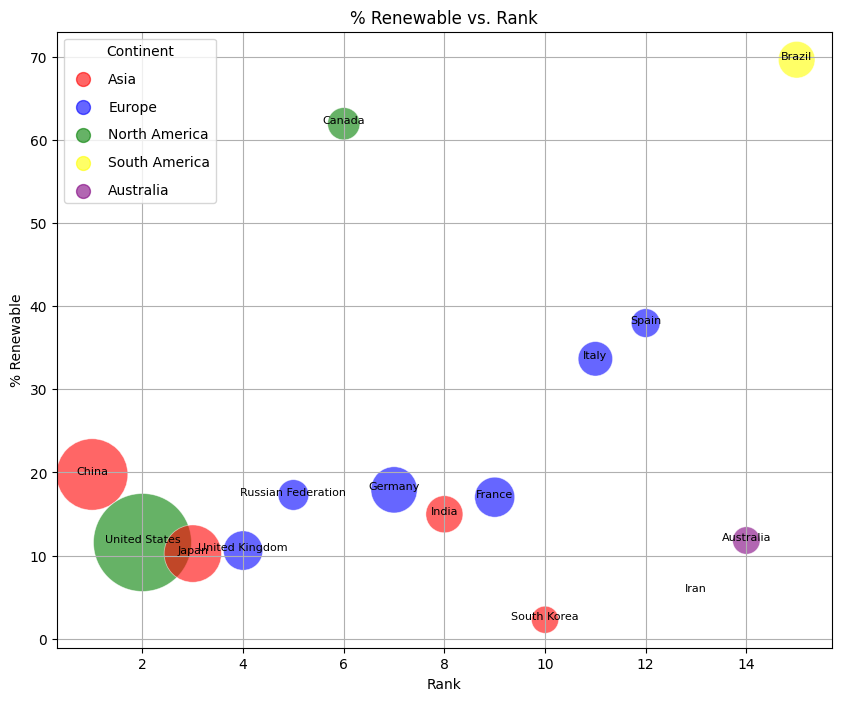

In [155]:
import matplotlib.pyplot as plt


def create_bubble_chart():
    colors = {
        "Asia": "red",
        "Europe": "blue",
        "North America": "green",
        "South America": "yellow",
        "Australia": "purple",
    }

    dataset["Color"] = dataset["Continent"].map(colors)

    plt.figure(figsize=(10, 8))
    plt.scatter(
        dataset["Rank"],
        dataset[RENEWABLE_COLUMN],
        s=dataset["2015"] / 1e10 * 3,
        c=dataset["Color"],
        alpha=0.6,
        edgecolors="w",
        linewidth=0.5,
    )

    for _, row in dataset.iterrows():
        plt.annotate(
            row.name, (row["Rank"], row[RENEWABLE_COLUMN]), fontsize=8, ha="center"
        )

    plt.xlabel("Rank")
    plt.ylabel("% Renewable")
    plt.title("% Renewable vs. Rank")
    plt.grid(True)

    for continent, color in colors.items():
        plt.scatter([], [], c=color, alpha=0.6, s=100, label=continent)
    plt.legend(scatterpoints=1, frameon=True, labelspacing=1, title="Continent")

    plt.show()


create_bubble_chart()